<a href="https://colab.research.google.com/github/gjurcin/nlp_sentiment_analysis/blob/main/IMDB_Sentiment_WS_gj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB - sentiment analysis
The problem is IMDB movie review sentiment classification. Each movie review is a variable sequence of words and the sentiment of each movie review must be classified.

The IMDB Dataset (http://ai.stanford.edu/~amaas/data/sentiment/) contains 25,000 movie reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given movie review has a positive or negative sentiment (binary classification).

The dataset is already split on train and test sequences and it can be dowloaded here:
  - Train: https://drive.google.com/file/d/1wVLamtBxnE2ickWoWEjw-a9GikppTNOn/view?usp=sharing
  - Test: https://drive.google.com/file/d/1frUKZOeO3qXMfJApsl24s1eOAcV6l0_Y/view?usp=sharing


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input,Embedding,LSTM,Dense, Dropout, GRU

import pickle

## Read the data
Each files ('xTrain_yTrain.pkl' and 'xTest_yTest.pkl')contains two lists of data. The first list contains sentences/reviews and the second list contains the labels.

The files can be read using pickle:

my_file = open('xTrain_yTrain.pkl', "rb")

X, Y = pickle.load(my_file)

my_file.close()

In [3]:
from google.colab import files
uploaded = files.upload()

Saving xTest_yTest.pkl to xTest_yTest.pkl
Saving xTrain_yTrain.pkl to xTrain_yTrain.pkl


In [4]:
train_file = open('xTrain_yTrain.pkl', "rb")

X_train, Y_train = pickle.load(train_file)

train_file.close()

In [5]:
test_file = open('xTest_yTest.pkl', "rb")

X_test, Y_test = pickle.load(test_file)

test_file.close()

## Inspect the data

  - Print several train and test examples with their labels
  - Plot the distribution of the labels both in the train and in the test 

In [6]:
print(X_train[0:5],'\n', Y_train[0:5],'\n', X_test[0:5],'\n', Y_test[0:5],'\n')

["the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but w

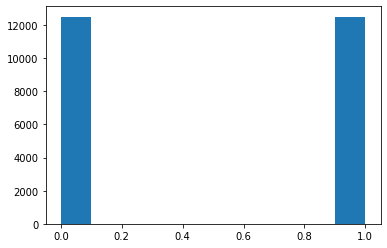

In [7]:
# train labels distrubution
plt.hist(Y_train)
plt.show()

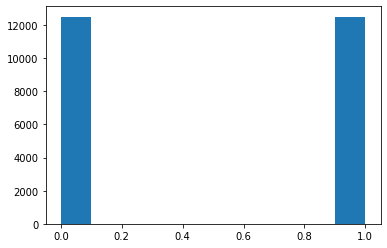

In [8]:
# test label distribution
plt.hist(Y_test)
plt.show()

## Preprocess the data

- covert to lower letters
- remove punctuation
- tokenization
- stop-words removal 
- lemmatization (use also Part of Speech tagger)

In [9]:
nltk.download('punkt')

nltk.download('stopwords')

stopwords_ = stopwords.words('english')

nltk.download('wordnet')

wnl = WordNetLemmatizer()

nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [10]:
X = X_train + X_test

In [11]:
text_preprocessed = []
for sentence in X:
    #sentence lower
    sentence = sentence.lower()
    #string punct
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    #tokenize
    tokens = nltk.word_tokenize(sentence)
    # stop-words
    tokens_stop_words = []
    for token in tokens:
      if token not in stopwords_:
        tokens_stop_words.append(token)
    # Lemmatization
    tokens_lemma = []
    for token in tokens_stop_words:
      tokens_lemma.append(wnl.lemmatize(token, get_wordnet_pos(nltk.pos_tag([token])[0][1])))
    final = ' '.join(tokens_lemma)
    text_preprocessed.append(final)

In [12]:
text_preprocessed[:5], len(text_preprocessed)

(['powerful let love becomes reach journalist lot anyone atmosphere never room titillate heart show year every never go villaronga help moment every chest visual movie except several enough current film mine potentially unfortunately get camp movie sometimes movie scary pratfall story wonderful see character 70 musician heart shadow serious critic isnt one tricky see land anyone gilmores br show whether history name half br n odd two mean 1 boat thought frog script history heart real barrel one bit two script nobody wasnt arm act watch heartfelt film want',
  'thought solid thought senator make spot nomination assume jack picked get hand fact character always life thriller cant br sure way little strongly random view love principle guy use producer icon film outside dont unique like direction imagination keep queen diverse make stretch stefan solid thought begin br senator machination budget worthwhile though ok brokedown await ever well lugia diverse budget look kick make bosworths fo

## Count Vector model

- use Count Vectorizer to create the feature vectors
- Train two models: Logistic Regression and LinearSVC
- Evaluate the model on the test data (calculate: accuracy, precision, recall and F1-score for each class, and the confusion matrix)


In [13]:
trainX, testX = text_preprocessed[:len(X_train)], text_preprocessed[len(X_train):]
trainY, testY = Y_train, Y_test
len(trainX), len(testX) ,len(trainY), len(testY)

(25000, 25000, 25000, 25000)

In [14]:
# Count Vectors as features
# create a count vectorizer object 
count_vect = CountVectorizer()
count_vect.fit(text_preprocessed)

# transform the training and test data using count vectorizer object
trainX_vec = count_vect.transform(trainX)
testX_vec = count_vect.transform(testX)
trainX_vec.shape,testX_vec.shape

((25000, 64266), (25000, 64266))

In [15]:
trainX_vec[0], trainX[0]

(<1x64266 sparse matrix of type '<class 'numpy.int64'>'
 	with 72 stored elements in Compressed Sparse Row format>,
 'powerful let love becomes reach journalist lot anyone atmosphere never room titillate heart show year every never go villaronga help moment every chest visual movie except several enough current film mine potentially unfortunately get camp movie sometimes movie scary pratfall story wonderful see character 70 musician heart shadow serious critic isnt one tricky see land anyone gilmores br show whether history name half br n odd two mean 1 boat thought frog script history heart real barrel one bit two script nobody wasnt arm act watch heartfelt film want')

In [16]:
#create an instance of the model
lr_model = LogisticRegression(random_state=7, max_iter=5000)
#train the model
lr_model.fit(trainX_vec, trainY)

#predict test data
pred_test = lr_model.predict(testX_vec)

#print evaluation metrics 
print(classification_report(testY,pred_test))
confusion_matrix(testY,pred_test)
print("Accuracy:",np.round(accuracy_score(testY, pred_test), 2))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.84      0.83      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

Accuracy: 0.84


In [17]:
#create an instance of the model
l_svc_model = LinearSVC()
#train the model
l_svc_model.fit(trainX_vec, trainY)

#predict test data
pred_test_svc = l_svc_model.predict(testX_vec)

#print evaluation metrics 
print(classification_report(testY,pred_test_svc))
confusion_matrix(testY,pred_test_svc)
print("Accuracy:",np.round(accuracy_score(testY, pred_test_svc), 2))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82     12500
           1       0.83      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

Accuracy: 0.81


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## TF-IDF 

- use TfidfVectorizer to create the feature vectors
- Train two models: Logistic Regression and LinearSVC
- Evaluate the model on the test data (calculate: accuracy, precision, recall and F1-score for each class, and the confusion matrix)

In [18]:
tfidf = TfidfVectorizer()
tfidf.fit(text_preprocessed)

X_train_tfidf = tfidf.transform(trainX)
X_test_tfidf = tfidf.transform(testX)

X_train_tfidf.shape, X_test_tfidf.shape

((25000, 64266), (25000, 64266))

In [19]:
#train the model
lr_model.fit(X_train_tfidf, trainY)

#predict test data
pred_test_tfidf = lr_model.predict(X_test_tfidf)

#print evaluation metrics 
print(classification_report(testY, pred_test_tfidf))
confusion_matrix(testY, pred_test_tfidf)
print("Accuracy:",np.round(accuracy_score(testY, pred_test_tfidf), 2))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Accuracy: 0.86


In [20]:
#train the model
l_svc_model.fit(X_train_tfidf, trainY)

#predict test data
pred_test_tfidf_svc = l_svc_model.predict(X_test_tfidf)

#print evaluation metrics 
print(classification_report(testY, pred_test_tfidf_svc))
confusion_matrix(testY, pred_test_tfidf_svc)
print("Accuracy:",np.round(accuracy_score(testY, pred_test_tfidf_svc), 2))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

Accuracy: 0.85


## WordEmbeddings model

In additioan to the previous pre-processing steps:

- Truncate and pad the input sequences so that they are all the same length for modeling, size = 30 (use sequence.pad_sequences)
- Train two Keras Sequential model with: 

  * Embedding layer (20 units), LSTM layer (20 units), Dense layer (1 unit). 
  * Embedding layer (50 units), LSTM layer (20 units), Dense layer (1 unit). 

- Evaluate the models

In [21]:
#The word embedding layer expects input sequences to be comprised of integers.
# integer encode sequences of words
tokenizer = Tokenizer()

tokenizer.fit_on_texts(text_preprocessed)

sequences = tokenizer.texts_to_sequences(text_preprocessed)
len(sequences), len(sequences[0]), len(sequences[1])

(50000, 89, 97)

In [22]:
povrat = tokenizer.sequences_to_texts(sequences)

In [23]:
len(povrat[0])

558

In [24]:
len(sequences[0]), len(text_preprocessed[0])

(89, 558)

In [25]:
tokenizer.word_index

{'br': 1,
 'movie': 2,
 'film': 3,
 'one': 4,
 'make': 5,
 'like': 6,
 'see': 7,
 'get': 8,
 'well': 9,
 'time': 10,
 'good': 11,
 'character': 12,
 'watch': 13,
 'go': 14,
 'bad': 15,
 'story': 16,
 'even': 17,
 'would': 18,
 'really': 19,
 'scene': 20,
 'show': 21,
 'much': 22,
 'look': 23,
 'great': 24,
 'say': 25,
 'end': 26,
 'people': 27,
 'also': 28,
 'think': 29,
 'first': 30,
 'way': 31,
 'dont': 32,
 'give': 33,
 'know': 34,
 'love': 35,
 'act': 36,
 'take': 37,
 'come': 38,
 'life': 39,
 'thing': 40,
 'could': 41,
 'seem': 42,
 'two': 43,
 'plot': 44,
 'year': 45,
 'work': 46,
 'many': 47,
 'actor': 48,
 'want': 49,
 'never': 50,
 'best': 51,
 'little': 52,
 'try': 53,
 'man': 54,
 'ever': 55,
 'play': 56,
 'still': 57,
 'find': 58,
 'part': 59,
 'something': 60,
 'back': 61,
 'old': 62,
 'director': 63,
 'feel': 64,
 'im': 65,
 'real': 66,
 'lot': 67,
 'though': 68,
 'star': 69,
 'performance': 70,
 'cast': 71,
 'woman': 72,
 'doesnt': 73,
 '10': 74,
 'use': 75,
 'u': 76,
 

In [26]:
sequences = np.array(sequences)

train_X, test_X =sequences[:len(X_train)], sequences[len(X_train):]

print(train_X.shape,test_X.shape)

(25000,) (25000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [27]:
max_len = 300
#transforms a list (of length num_samples) of sequences (lists of integers) 
#into a 2D Numpy array of shape (num_samples, num_timesteps) num_timesteps is the maxlen argument.
train_X_pad = pad_sequences(train_X, maxlen=max_len)
test_X_pad = pad_sequences(test_X, maxlen=max_len)
print(train_X_pad.shape)
print(test_X_pad.shape)

(25000, 300)
(25000, 300)


In [28]:
train_X_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [29]:
#We need to know the size of the vocabulary for defining the embedding layer.
vocab_size = len(tokenizer.word_index) + 1
vocab_size

64676

In [30]:
def generate_model(vocab_size, max_len, embedding_size):

  _input = Input(max_len)
  x = Embedding(input_dim = vocab_size, output_dim = embedding_size, input_length=max_len) (_input)
  x_lstm = GRU(20)(x)
  x_dropout = Dropout(rate=0.2)(x_lstm)
  output = Dense(1, activation='sigmoid')(x_dropout)
  model = Model(inputs= [_input], outputs = [output])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
  
model_1 = generate_model(vocab_size, max_len, embedding_size=500)
model_1.summary()

history_1 = model_1.fit(train_X_pad, trainY, epochs=10, batch_size=60)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 500)          32338000  
_________________________________________________________________
gru (GRU)                    (None, 20)                31320     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 32,369,341
Trainable params: 32,369,341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
417/417 [==============================] - 142s 323ms/step - loss: 0.5430 - accuracy: 0.7114
Epoch 2/10


In [31]:
pred_test_embed = model_1.predict(test_X_pad)
#pred_test = np.argmax(pred_test,axis=1)
pred_test_embed = pred_test_embed.round()

#print evaluation metrics 
print(classification_report(testY, pred_test_embed))
print(confusion_matrix(testY, pred_test_embed))
print("Accuracy:", np.round(accuracy_score(testY, pred_test_embed),2))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     12500
           1       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000

[[10231  2269]
 [ 2224 10276]]
Accuracy: 0.82


# Create a report/table for the experimental results. 

  - The table should contain accuracy, f1-score, precision and recall for each of the 6 models
  - Write few sentences about which model performed the best in your opinion (and why).

## Use the model on unseen data

  - Find 3 english reviews (for which it is clear whether they are Good or Bad) from your favourite movie on IMDB
  - Use the best model to classify them